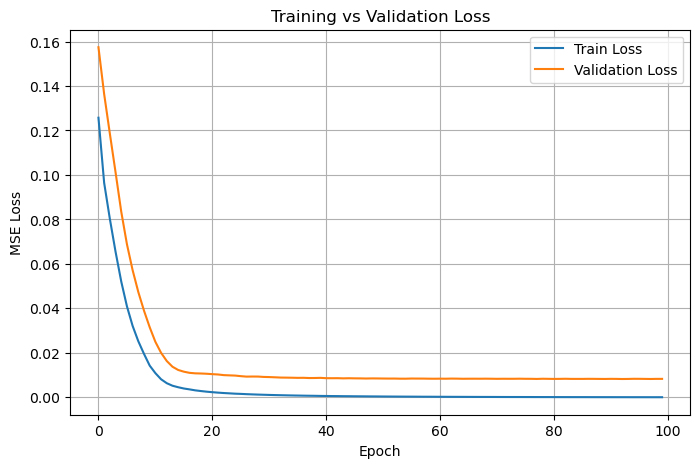

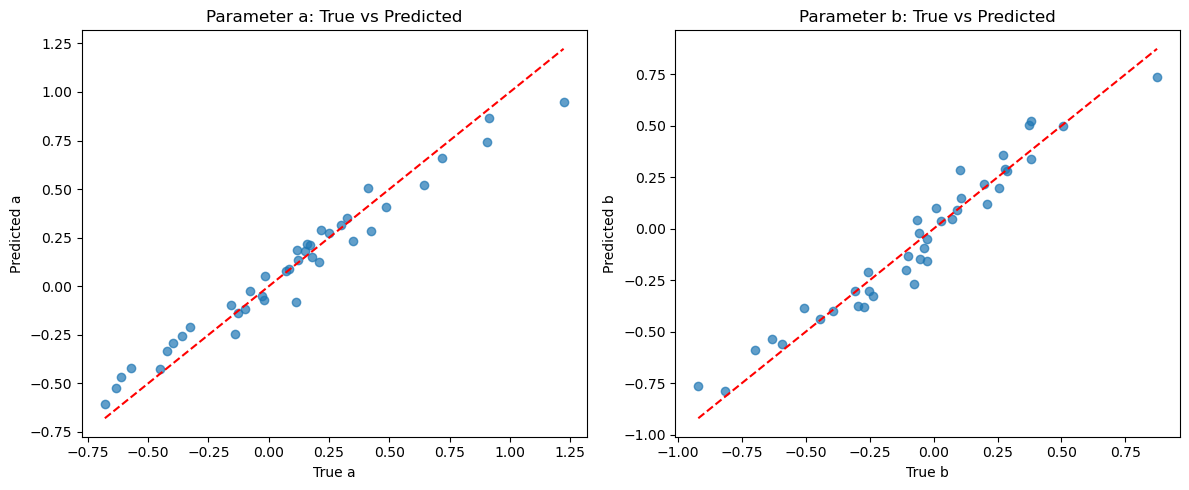

In [1]:
# mlp_regression_from_latent.ipynb
# Liya Ding with help from ChatGPT, 2025.04.

# Section 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# === [OPTIONAL] Generate synthetic data for testing ===
# Comment this out if using real data

import numpy as np

np.random.seed(42)
N = 200
Z = np.random.randn(N, 13).astype(np.float32)

# Synthetic targets (a and b) depend on combinations of features + noise
a = (Z[:, 0] + 1.5 * Z[:, 1]) * 0.2 + np.random.randn(N) * 0.05
b = (Z[:, 2] - 0.8 * Z[:, 3]) * 0.3 + np.random.randn(N) * 0.05

# Save for future runs or testing
np.save("Z_features.npy", Z)
np.save("parameter_a.npy", a)
np.save("parameter_b.npy", b)


# Section 2: Load data
# Replace with your actual .npy file paths
Z = np.load("Z_features.npy")            # Shape: (N, 13)
a = np.load("parameter_a.npy")           # Shape: (N,)
b = np.load("parameter_b.npy")           # Shape: (N,)
y = np.stack([a, b], axis=1).astype(np.float32)

# Section 3: Train-validation split
Z_train, Z_val, y_train, y_val = train_test_split(Z, y, test_size=0.2, random_state=42)

# Section 4: Dataset and DataLoader
class LatentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(LatentDataset(Z_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(LatentDataset(Z_val, y_val), batch_size=32)

# Section 5: Define MLP Model
class MLPRegressor(nn.Module):
    def __init__(self, in_dim=13, hidden_dim=64, out_dim=2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.mlp(x)

model = MLPRegressor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Section 6: Training loop
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb.size(0)
    train_losses.append(total_train_loss / len(train_loader.dataset))

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            total_val_loss += loss.item() * xb.size(0)
    val_losses.append(total_val_loss / len(val_loader.dataset))

# Section 7: Plot training/validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

# Section 8: Evaluate predictions
model.eval()
with torch.no_grad():
    val_preds = model(torch.tensor(Z_val, dtype=torch.float32)).numpy()

# Section 9: Plot predictions vs ground truth
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(y_val[:, 0], val_preds[:, 0], alpha=0.7)
axs[0].plot([y_val[:, 0].min(), y_val[:, 0].max()],
            [y_val[:, 0].min(), y_val[:, 0].max()], 'r--')
axs[0].set_title("Parameter a: True vs Predicted")
axs[0].set_xlabel("True a")
axs[0].set_ylabel("Predicted a")

axs[1].scatter(y_val[:, 1], val_preds[:, 1], alpha=0.7)
axs[1].plot([y_val[:, 1].min(), y_val[:, 1].max()],
            [y_val[:, 1].min(), y_val[:, 1].max()], 'r--')
axs[1].set_title("Parameter b: True vs Predicted")
axs[1].set_xlabel("True b")
axs[1].set_ylabel("Predicted b")

plt.tight_layout()
plt.show()